# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
import seaborn as sns
sns.set_style('whitegrid')

# Convenience Functions

Below are some convenience functions that are helpful for the rest of the notebook.

In [2]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

# Returns the first (and oldest) date (assuming date is the index) of a series or DataFrame
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    return t0

# Returns the last (and most recent) date (assuming date is the index) of a series or DataFrame
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75    
    return t_present

# Returns an array of numeric dates between t0 and t1 at a specified sample rate
def calculate_date_range(t0, t1, sample_rate):
    return np.linspace(t0, t1, int((t1-t0)*sample_rate) + 1)

# Takes in text based dates (e.g. 2022 Q4) and returns an array of decimalised dates
def convert_dates_to_numeric(data):
    dates = np.zeros(len(data))
    for i in np.arange(len(data)):
        year = int(data.index[i][:4])
        quarter = data.index[i][-2:]
        if quarter == 'Q1':
            d = year + 0
        elif quarter == 'Q2':
            d = year + 0.25
        elif quarter == 'Q3':
            d = year + 0.5
        elif quarter == 'Q4':
            d = year + 0.75
        dates[i] = d
    return dates

# Read in Data

### VEH1153: Vehicles registered for the first time by body type and fuel type

In [3]:
drop_cols_veh1153 = [
    'Units',
]

veh1153 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1153.ods", 
        engine="odf", 
        sheet_name='VEH1153a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Date Interval [note 4]': 'Date Interval',
            'Date [note 4]': 'Date',
            'Other vehicles [note 3]': 'Other vehicles',
            'Gas [note 5]': 'Gas',
            'Other fuel types [note 6]': 'Other fuel types',
            'Plug-in [note 7]': 'Plug-in',
            'Zero emission [note 8]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1153, axis=1)
)

# Convert units from Thousands to real counts
veh1153.iloc[:, 4:] = veh1153.iloc[:, 4:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1153['ICE'] = veh1153['Total'] - veh1153['Plug-in'] - veh1153['Fuel cell electric']

# Remove bracketed text from Dates
veh1153['Date'] = veh1153['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1153.head()

,Geography,Date Interval,Date,BodyType,Petrol,Diesel,Hybrid electric (petrol),Hybrid electric (diesel),Plug-in hybrid electric (petrol),Plug-in hybrid electric (diesel),Battery electric,Range extended electric,Fuel cell electric,Gas,Other fuel types,Total,Plug-in,Zero emission,ICE
374,England,Annual,2001,Cars,1874649.0,405214.0,604.0,3.0,0.0,0.0,81.0,0.0,0.0,1954.0,7.0,2282512.0,81.0,81.0,2282431.0
375,England,Annual,2002,Cars,1793879.0,563102.0,270.0,0.0,0.0,0.0,58.0,0.0,1.0,2311.0,3.0,2359624.0,58.0,59.0,2359565.0
376,England,Annual,2003,Cars,1679322.0,641920.0,351.0,0.0,0.0,0.0,39.0,0.0,3.0,3086.0,6.0,2324727.0,39.0,42.0,2324685.0
377,England,Annual,2004,Cars,1524998.0,749242.0,1442.0,0.0,0.0,0.0,90.0,0.0,2.0,1681.0,8.0,2277463.0,90.0,92.0,2277371.0
378,England,Annual,2005,Cars,1343752.0,794699.0,4997.0,3.0,0.0,0.0,223.0,0.0,4.0,482.0,13.0,2144173.0,223.0,227.0,2143946.0


### VEH1103: Licensed vehicles at the end of the quarter by body type and fuel type

In [4]:
drop_cols_veh1103 = [
    'Units',
]

veh1103 = (
    pd.read_excel(
        "../../data/vehicle_data/veh1103.ods", 
        engine="odf", 
        sheet_name='VEH1103a_RoadUsing', 
        skiprows=4, 
        na_values=['[c]', '[x]']
    )
    .rename(
        columns={
            'Geography [note 3]': 'Geography',
            'Gas [note 4]': 'Gas',
            'Other fuel types [note 5]': 'Other fuel types',
            'Plug-in [note 6]': 'Plug-in',
            'Zero emission [note 7]': 'Zero emission'
        }
    )
    .query("BodyType == 'Cars' and Units == 'Thousands'")
    .drop(drop_cols_veh1103, axis=1)
)

# Convert units from Thousands to real counts
veh1103.iloc[:, 3:] = veh1103.iloc[:, 3:]*1000

# Approximate the number of ICE vehicles given the total, plug-in and fuel-cell electric vehicles
veh1103['ICE'] = veh1103['Total'] - veh1103['Plug-in'] - veh1103['Fuel cell electric']

# Remove bracketed text from Dates
veh1103['Date'] = veh1103['Date'].str.replace(r"\(.*\)","", regex=True).str.strip()

veh1103.head()

,Geography,Date,BodyType,Petrol,Diesel,Hybrid electric (petrol),Hybrid electric (diesel),Plug-in hybrid electric (petrol),Plug-in hybrid electric (diesel),Battery electric,Range extended electric,Fuel cell electric,Gas,Other fuel types,Total,Plug-in,Zero emission,ICE
72,England,1994 Q4,Cars,16694257.0,1313637.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0,1543.0,192.0,18009710.0,81.0,81.0,18009629.0
73,England,1995 Q4,Cars,16635739.0,1573698.0,0.0,0.0,0.0,0.0,61.0,0.0,0.0,2518.0,121.0,18212137.0,61.0,61.0,18212076.0
74,England,1996 Q4,Cars,17149424.0,1811387.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0,3587.0,107.0,18964584.0,79.0,79.0,18964505.0
75,England,1997 Q4,Cars,17505628.0,2031080.0,0.0,0.0,0.0,0.0,101.0,0.0,0.0,5577.0,104.0,19542490.0,101.0,101.0,19542389.0
76,England,1998 Q4,Cars,17744318.0,2247998.0,0.0,0.0,0.0,0.0,140.0,0.0,0.0,8650.0,100.0,20001206.0,140.0,140.0,20001066.0


### LSOA Lookup Data

In [5]:
LAD = 'Bath and North East Somerset' # Target Local Authority District

In [6]:
lsoa_lookup = pd.read_csv('../../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,CHGIND,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01000001,City of London 001A,E01000001,City of London 001A,U,E09000001,City of London,NaN,1
1,E01000002,City of London 001B,E01000002,City of London 001B,U,E09000001,City of London,NaN,2
2,E01000003,City of London 001C,E01000003,City of London 001C,U,E09000001,City of London,NaN,3
3,E01000005,City of London 001E,E01000005,City of London 001E,U,E09000001,City of London,NaN,4
4,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,U,E09000002,Barking and Dagenham,NaN,5


### Historical Total Vehicle Registration Data for LSOAs

In [7]:
v_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
    .query("BodyType == 'Cars' and Keepership == 'Private' and LicenceStatus == 'Licensed'")
    .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD] # Filter for target Local Authority (BNES)
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
v_lsoa = v_lsoa[~v_lsoa.index.duplicated(keep='first')]

v_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,361.0,353.0,357.0,352.0,369.0,390.0,382.0,380.0,371.0,372.0,...,390.0,397.0,391.0,393.0,384.0,389.0,406.0,378.0,384.0,386.0
E01014371,502.0,512.0,507.0,524.0,517.0,524.0,524.0,530.0,523.0,512.0,...,537.0,552.0,546.0,557.0,552.0,540.0,538.0,549.0,547.0,557.0
E01014372,495.0,507.0,506.0,509.0,513.0,508.0,506.0,508.0,500.0,479.0,...,548.0,553.0,556.0,552.0,571.0,561.0,588.0,604.0,595.0,591.0
E01014373,753.0,754.0,770.0,768.0,775.0,762.0,773.0,740.0,749.0,759.0,...,680.0,674.0,690.0,688.0,695.0,692.0,684.0,696.0,692.0,703.0
E01014374,752.0,762.0,759.0,756.0,746.0,750.0,741.0,739.0,727.0,718.0,...,632.0,627.0,632.0,637.0,634.0,633.0,637.0,628.0,627.0,641.0


### Historical Electric Vehicle Registration Data for LSOAs by Propulsion Type

In [8]:
ev_lsoa = (
    pd.read_csv('../../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
    .query("Keepership == 'Private'")
    .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LAD]
    .drop(columns = ['LAD22NM'])
    .set_index('LSOA11CD')
)

ev_lsoa.head()

,Fuel,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,Battery electric,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014370,Plug-in hybrid electric (petrol),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014370,Total,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,Battery electric,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,Plug-in hybrid electric (diesel),NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This now needs to be disaggregated by propulsion type.

#### Historical BEV Registration Data for LSOAs

In [9]:
bev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
bev_lsoa = bev_lsoa[~bev_lsoa.index.duplicated(keep='first')]

bev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,9.0,8.0,7.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014371,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,7.0,5.0,5.0,5.0,NaN,5.0,5.0,5.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,10.0,12.0,11.0,11.0,11.0,9.0,7.0,7.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,20.0,17.0,18.0,18.0,15.0,15.0,10.0,8.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Historical PHEV Registration Data for LSOAs

In [10]:
phev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
phev_lsoa = phev_lsoa[~phev_lsoa.index.duplicated(keep='first')]

phev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,5.0,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,12.0,11.0,10.0,9.0,8.0,7.0,5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Historical EV Registration Data for LSOAs

In [11]:
total_ev_lsoa = (
    ev_lsoa
    .query("Fuel == 'Total' or Fuel.isnull()") # Fill in missing rows
    .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)

# Drop duplicate rows
total_ev_lsoa = total_ev_lsoa[~total_ev_lsoa.index.duplicated(keep='first')]

total_ev_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,13.0,12.0,10.0,11.0,11.0,8.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
E01014371,10.0,11.0,10.0,10.0,7.0,7.0,7.0,6.0,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014372,12.0,9.0,9.0,8.0,8.0,11.0,10.0,9.0,9.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014373,14.0,15.0,15.0,15.0,15.0,13.0,11.0,11.0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01014374,34.0,30.0,30.0,29.0,24.0,23.0,16.0,13.0,10.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Historical ICE Registration Data for LSOAs

The difference between the total vehicle and EV registration is assumed to be the ICE registration.

In [12]:
ice_lsoa = v_lsoa.subtract(total_ev_lsoa)
ice_lsoa = ice_lsoa[ice_lsoa.columns[::-1]]
ice_lsoa.head()

,2022 Q4,2022 Q3,2022 Q2,2022 Q1,2021 Q4,2021 Q3,2021 Q2,2021 Q1,2020 Q4,2020 Q3,...,2012 Q1,2011 Q4,2011 Q3,2011 Q2,2011 Q1,2010 Q4,2010 Q3,2010 Q2,2010 Q1,2009 Q4
LSOA11CD,,,,,,,,,,,,,,,,,,,,,
E01014370,348.0,341.0,347.0,341.0,358.0,382.0,376.0,NaN,NaN,NaN,...,390.0,397.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014371,492.0,501.0,497.0,514.0,510.0,517.0,517.0,524.0,NaN,NaN,...,537.0,552.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014372,483.0,498.0,497.0,501.0,505.0,497.0,496.0,499.0,491.0,472.0,...,548.0,553.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014373,739.0,739.0,755.0,753.0,760.0,749.0,762.0,729.0,739.0,750.0,...,680.0,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E01014374,718.0,732.0,729.0,727.0,722.0,727.0,725.0,726.0,717.0,709.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# "Global" Variables

In [15]:
RANDOM_SEED = 42

sample_rate = 4 # Quarterly
region = 'England'

# Inital estimates for BEV and PHEV lifetimes
bev_lifetime = 12 # Years
phev_lifetime = 15 # Years

horizon = 2050 # How far into the future we're looking

ice_ban = 2030 # The year in which the sale of new ICE vehicles is banned in the UK
phev_ban = 2035 # The year in which the sale of new Hybrid vehicles is banned in the UK

# Interpolate Missing Registration Data

- Historical registration data is not reported if the number of registered vehicles in an LSOA is: $0 < n < 5$.
- Therefore, missing registration data is interpolated in order to better capture trends in EV registration.

In [16]:
# Interpolates missing registration data
def interpolate_registration_data(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)

    interpolated_df = interpolated_df.fillna(0)
    
    return interpolated_df

In [17]:
bev_lsoa_i = interpolate_registration_data(bev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
phev_lsoa_i = interpolate_registration_data(phev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_ev_lsoa_i = interpolate_registration_data(total_ev_lsoa.T.iloc[::-1], sample_rate=sample_rate)
total_lsoa_i = interpolate_registration_data(v_lsoa.T.iloc[::-1], sample_rate=sample_rate)

# Doing this afterwards with interpolated data reduces the number of NaNs
ice_lsoa_i = total_lsoa_i.subtract(total_ev_lsoa_i)
ice_lsoa_i.tail()

LSOA11CD,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01014478,E01014479,E01014480,E01014481,E01014482,E01014483,E01014484,E01033078,E01033079,E01033080
2021 Q4,358.0,510.0,505.0,760.0,722.0,827.0,979.0,806.0,1320.0,722.0,...,469.0,656.0,549.0,382.0,598.0,441.0,383.0,1015.0,716.0,582.0
2022 Q1,341.0,514.0,501.0,753.0,727.0,820.0,992.0,806.0,1324.0,723.0,...,459.0,654.0,546.0,377.0,604.0,437.0,377.0,999.0,708.0,592.0
2022 Q2,347.0,497.0,497.0,755.0,729.0,814.0,986.0,802.0,1310.0,727.0,...,451.0,651.0,544.0,369.0,600.0,434.0,390.0,983.0,703.0,585.0
2022 Q3,341.0,501.0,498.0,739.0,732.0,815.0,965.0,788.0,1310.0,731.0,...,452.0,652.0,545.0,382.0,600.0,431.0,397.0,974.0,684.0,570.0
2022 Q4,348.0,492.0,483.0,739.0,718.0,784.0,968.0,788.0,1308.0,720.0,...,455.0,651.0,535.0,387.0,596.0,424.0,396.0,968.0,692.0,582.0


# Approximate Vehicle Retirement Rates

- I am assuming that the retirement rate of ICE vehicles is equal to the quarterly number of retired ICEs divided by the total number of registered ICEs. This represents the proportion of the ICE stock that retire each quarter. The inverse of this would give an estimate for the average lifespan of an ICE. This works out at around 18 years.
- I should probably calculate retirement rates for each LSOA. For instance, one LSOA might have a high throughput of vehicles, whilst another might retain vehicles for longer.

In [18]:
# Number of ICE vehicles currently registered in the "region"
n_ice = veh1103.loc[(veh1103['Geography'] == region), 'ICE'].iloc[-1]
n_ice

26459296.0

In [19]:
# ICE Retirements
ice_retirements = (veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
                       veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()).mean() # Per Quarter
ice_retirement_rate = ice_retirements/n_ice
ice_retirement_rate

0.013699838888672334

In [20]:
bev_retirement_rate = 1/(4*bev_lifetime)
bev_retirement_rate

0.020833333333333332

In [21]:
phev_retirement_rate = 1/(4*phev_lifetime)
phev_retirement_rate

0.016666666666666666

# Estimate New Vehicle Registrations in each LSOA

- The rolling averaging of the new vehicle approximations helps to eliminate any "high-frequency" noise in the data and makes the interpolation of sales shares more reliable.
- In this case, I'm mostly interested in the most recent value for new vehicles since this is what the forecast trajectory for sales share is based off.

In [22]:
rolling_average_window = 8 # Quarters

new_bev_lsoa = bev_lsoa_i.diff().add(bev_lsoa_i*bev_retirement_rate) # Approximate new BEV registrations per quarter
new_bev_lsoa[new_bev_lsoa < 0] = 0
smoothed_new_bev_lsoa = new_bev_lsoa.rolling(rolling_average_window).mean() # Calculate rolling average

new_phev_lsoa = phev_lsoa_i.diff().add(phev_lsoa_i*phev_retirement_rate) # Approximate new PHEV registrations per quarter
new_phev_lsoa[new_phev_lsoa < 0] = 0
smoothed_new_phev_lsoa = new_phev_lsoa.rolling(rolling_average_window).mean()

new_ice_lsoa = ice_lsoa_i.diff().add(ice_lsoa_i*ice_retirement_rate) # Approximate new ICE registrations per quarter
new_ice_lsoa[new_ice_lsoa < 0] = 0
smoothed_new_ice_lsoa = new_ice_lsoa.rolling(rolling_average_window).mean()

smoothed_new_vehicles_lsoa = sum([smoothed_new_ice_lsoa, smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])
smoothed_new_ev_lsoa = sum([smoothed_new_bev_lsoa, smoothed_new_phev_lsoa])

# Forecasting the Sales Share for Each Propulsion Type

Here's a description of the `calculate_sales_share` function:

1. `target`: Represents the number of new vehicle registrations of the target type over time.

2. `parent`: Represents the total number of new vehicle registrations for the parent vehicle type over the same time period (e.g. EV is the parent vehicle type of BEV and PHEV).

3. `ban`: The date at which legislative action or a ban comes into effect.

4. `value_at_ban`: The value to be assigned to sales shares after the ban date. In the absence of data, it is set to 0.5, representing a 50-50 share between the child vehicle types (e.g. BEVs and PHEVs).

5. `sales_share = target.divide(parent)`: This line calculates the sales share by dividing the target registrations by the parent registrations for each date. This gives the proportion of the target vehicle type relative to the parent for each time point.

6. The subsequent lines of code handle cases where sales shares are missing (NaN) or equal to 0. In such cases, the last entry of the sales share (at the latest date) is set to 0.5. This approach assumes that between the current date and the legislative ban, there's still a chance for regions to see a rise in vehicle ownership even if no registrations of the target type were recorded in the past.

7. `sales_share = sales_share.fillna(0)`: Any remaining NaNs (resulting from dividing by zero) in the sales share data are filled with 0. This step is done to avoid issues with division by zero.

8. The function converts the historical dates in the sales share DataFrame to numeric values using the `convert_dates_to_numeric` function.

9. `date_range = calculate_date_range(calculate_t0(sales_share), t1=horizon, sample_rate=sample_rate)`: A date range is generated from the earliest date in the sales share data to the horizon (future time point) at a specified sample rate.

10. `sales_share['Date_numeric'] = dates`: The converted date values are added as a new column ('Date_numeric') in the sales share DataFrame.

11. The DataFrame is then set to be indexed by the numeric dates, and it is reindexed to include all dates in the date range, ensuring all time points are accounted for.

12. Sales shares at the ban date are assigned the value specified in `value_at_ban`, representing either a 0 (if the vehicle type is banned) or 1 (if it is allowed).

13. The function performs linear interpolation to fill in missing sales share values for dates between the available data points. This step estimates sales shares for dates in the future.

14. The resulting DataFrame with sales share estimates for all dates is returned.

In [23]:
def calculate_sales_share(target, parent, ban, value_at_ban):
    sales_share = target.divide(parent) # Target = Vehicle type, parent = Parent vehicle type

    # The following sets any cell that contains NaN or 0 to 0.5 share as the last entry. 
    # Between the current date and the legislative ban there is still a chance that a region could see a rise in vehicle ownership
    # Despite there being no registrations of those vehicle types in the past.

    sales_share.iloc[-1] = sales_share.iloc[-1].fillna(0.5)
    sales_share.iloc[-1][sales_share.iloc[-1] == 0] = 0.5

    sales_share = sales_share.fillna(0) # 0.0/0.0 = NaN. Therefore, I replace the NaNs with 0 (Need to review this)
    
    dates = convert_dates_to_numeric(sales_share) # Historical Dates
    date_range = calculate_date_range(calculate_t0(sales_share), t1=horizon, sample_rate=sample_rate) # Current and Future Dates

    sales_share['Date_numeric'] = dates
    sales_share = sales_share.set_index('Date_numeric')
    sales_share = sales_share.reindex(date_range)

    # Linear Interpolation
    sales_share.loc[ban, :] = value_at_ban # 0 if banned vehicle type, 1 if beneficiary.
    sales_share = sales_share.interpolate()
    return sales_share

In [24]:
# ev_sales_share_lsoa = calculate_sales_share(smoothed_new_ev_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 1)
ice_sales_share_lsoa = calculate_sales_share(smoothed_new_ice_lsoa, smoothed_new_vehicles_lsoa, ice_ban, 0)
# bev_sales_share_lsoa = calculate_sales_share(smoothed_new_bev_lsoa, smoothed_new_ev_lsoa, phev_ban, 1)
phev_sales_share_lsoa = calculate_sales_share(smoothed_new_phev_lsoa, smoothed_new_ev_lsoa, phev_ban, 0)

<Axes: title={'center': 'Share of new EVs that are PHEVs in each LSOA'}, xlabel='Date_numeric'>

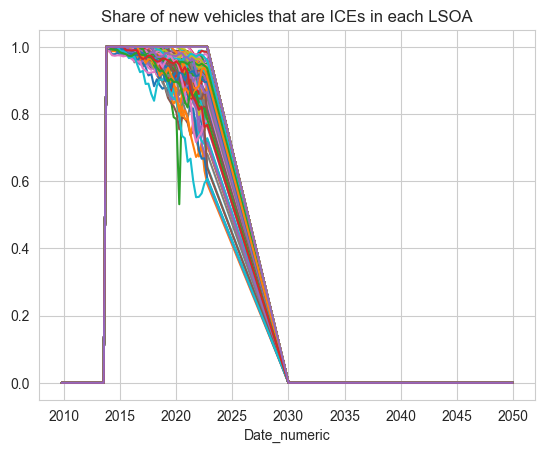

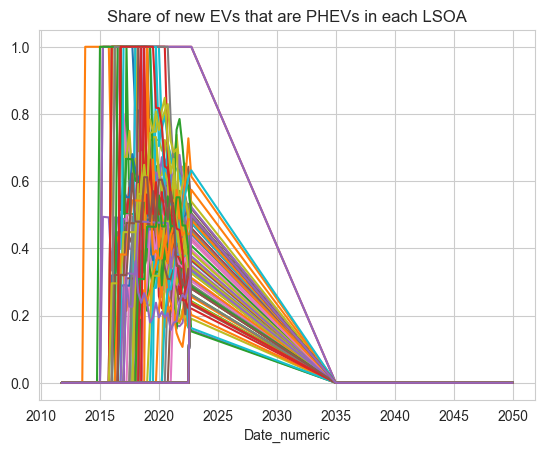

In [25]:
ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA')
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA')

# Incorporating Anticipatory behaviour

- This code models anticipatory behavior for ICE and PHEV vehicles, and then adjusts the sales shares of these vehicle types during a 10-year anticipatory period. 
- It uses an exponential growth function to model the changes in sales shares, and the adjusted sales shares are used to plot the changes in the shares of ICEs, EVs, PHEVs, and BEVs in each LSOA during the anticipatory period. 
- The code is helpful in understanding how vehicle sales shares may be influenced by anticipated changes in regulations or vehicle bans.
- *I currently have no idea what the parameters of this anticipatory component should be.*

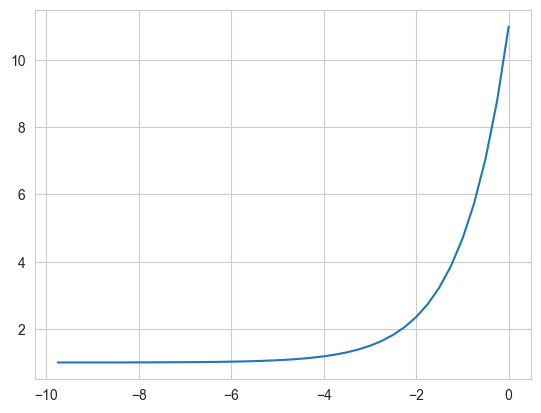

In [26]:
anticipatory_period = 10

x = np.linspace(-(anticipatory_period - (1/sample_rate)), 0, 40) # 10 years (40 quarters)

# ICE Anticipatory Parameters
a = 10
b = 1

y_ice = a * np.exp(b * x) + 1

# PHEV Anticipatory Parameters
c = 10
d = 1

y_phev = c * np.exp(d * x) + 1

plt.plot(x, y_ice)

<Axes: title={'center': 'Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)'}, xlabel='Date_numeric'>

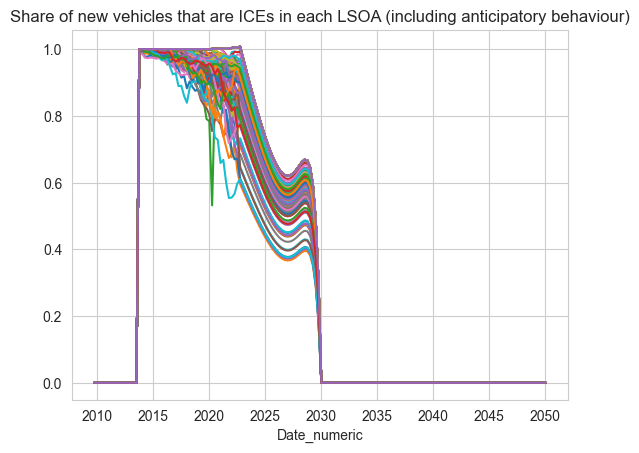

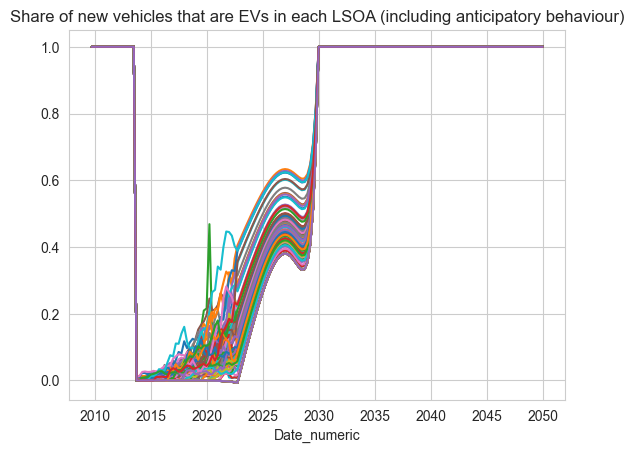

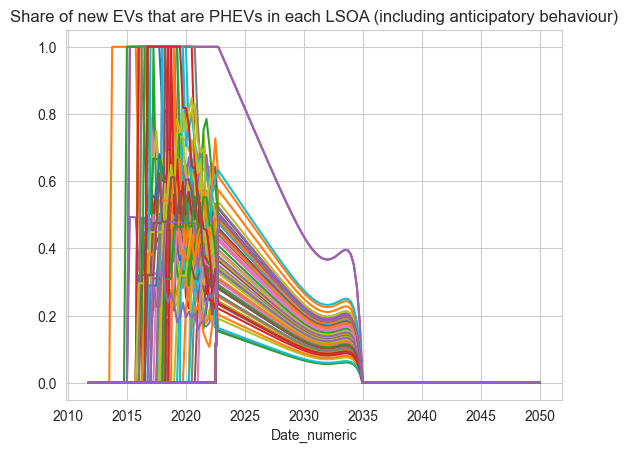

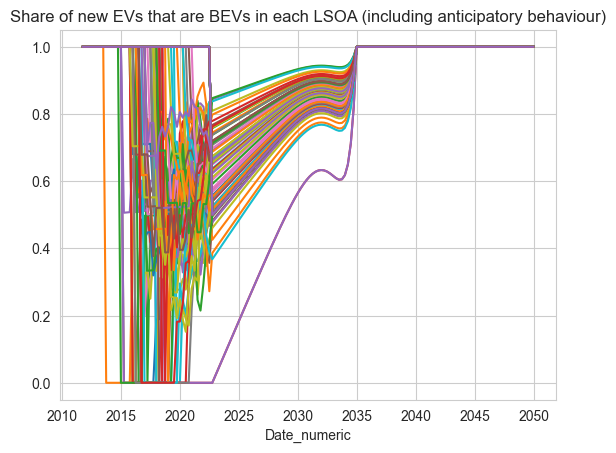

In [27]:
ice_sales_share_lsoa.loc[ice_ban - (anticipatory_period - (1/sample_rate)) : ice_ban] = ice_sales_share_lsoa.loc[ice_ban - (anticipatory_period - (1/sample_rate)) : ice_ban].multiply(y_ice, axis=0)
ev_sales_share_lsoa = 1 - ice_sales_share_lsoa

phev_sales_share_lsoa[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban] = phev_sales_share_lsoa.loc[phev_ban - (anticipatory_period - (1/sample_rate)) : phev_ban].multiply(y_phev, axis=0)
bev_sales_share_lsoa = 1 - phev_sales_share_lsoa

ice_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are ICEs in each LSOA (including anticipatory behaviour)')
ev_sales_share_lsoa.plot(legend=False, title='Share of new vehicles that are EVs in each LSOA (including anticipatory behaviour)')
phev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are PHEVs in each LSOA (including anticipatory behaviour)')
bev_sales_share_lsoa.plot(legend=False, title='Share of new EVs that are BEVs in each LSOA (including anticipatory behaviour)')

# Probabilistic Modelling of Future Vehicle Adoption

Trying to account for the uncertainty in overal new vehicle registrations.

In [28]:
# Bayesian Stuff
import pymc as pm
import arviz as az

### New Vehicle Registrations

<Axes: >

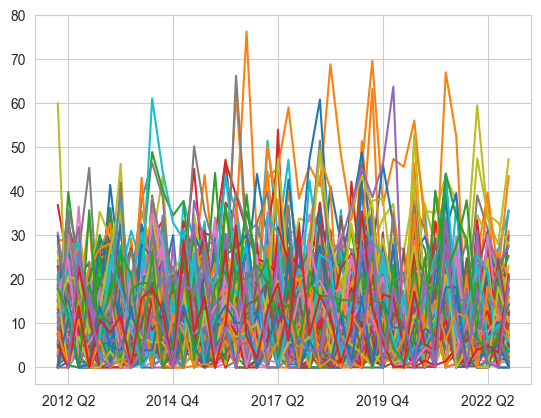

In [29]:
new_vehicles_lsoa = sum([new_ice_lsoa, new_bev_lsoa, new_phev_lsoa])
new_vehicles_lsoa.plot(legend=False)

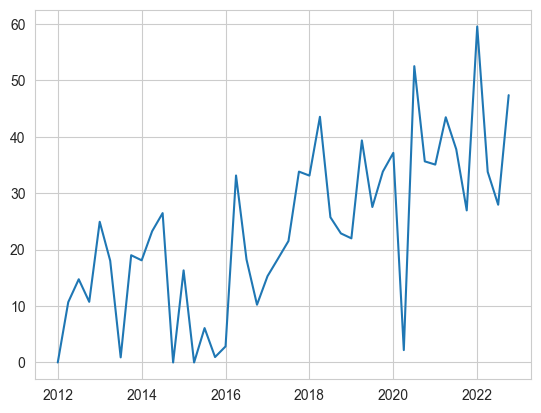

In [30]:
target_lsoa = 'E01014399'

target_lsoa_data = new_vehicles_lsoa[target_lsoa].dropna().to_numpy()
plt.plot(convert_dates_to_numeric(new_vehicles_lsoa.dropna()), target_lsoa_data)

- Here, we construct a Bayesian model to analyse the observed data for new vehicle registrations in a specific target LSOA (Local Super Output Area). 
- It uses PyMC, a probabilistic programming library, for Bayesian inference.

Here's a step-by-step explanation of the code:

1. `pm.Model()`: A PyMC model object is created to define the Bayesian model.

2. `mu = pm.Uniform('mu', lower=0, upper=np.max(target_lsoa_data))`: We define a Uniform prior distribution for the parameter `mu`, which represents the mean of the new vehicle registrations in the target LSOA. The prior is set to have a lower bound of 0 (non-negativity) and an upper bound equal to the maximum value of the observed data (`target_lsoa_data`). This prior expresses our belief about the range of possible values for the mean.
3. `sigma = pm.Uniform('sigma', lower=0, upper=50)`: Similarly, we define a Uniform prior distribution for the parameter `sigma`, which represents the standard deviation of the new vehicle registrations in the target LSOA. The prior is set to have a lower bound of 0 (non-negativity) and an upper bound of 50, indicating our uncertainty about the spread of the data.
4. `counts_observed = pm.TruncatedNormal('counts_observed', mu=mu, sigma=sigma, lower=0, observed=target_lsoa_data)`: Here, we specify the likelihood for the observed data `target_lsoa_data`. It assumes that the observed data follow a Normal distribution (TruncatedNormal), with mean `mu`, standard deviation `sigma`, and lower bound of 0 (since the number of new vehicle registrations cannot be negative). The `observed` parameter is set to `target_lsoa_data`, meaning that this observed data will be used to fit the model.
5. The code enters a new context (`with new_vehicle_model:`) to perform Bayesian inference using MCMC sampling.
6. `pm.sample(...)`: We use MCMC sampling to approximate the posterior distribution. It draws 1000 samples from the posterior, with 2000 tuning steps to adjust the sampling parameters. The `random_seed` is set to `RANDOM_SEED` for reproducibility.
7. `az.plot_trace(trace)`: After sampling is complete, Arviz is used to plot the trace of the sampled parameters. This visualisation allows us to inspect the convergence and behaviour of the MCMC chains and assess the model's performance.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

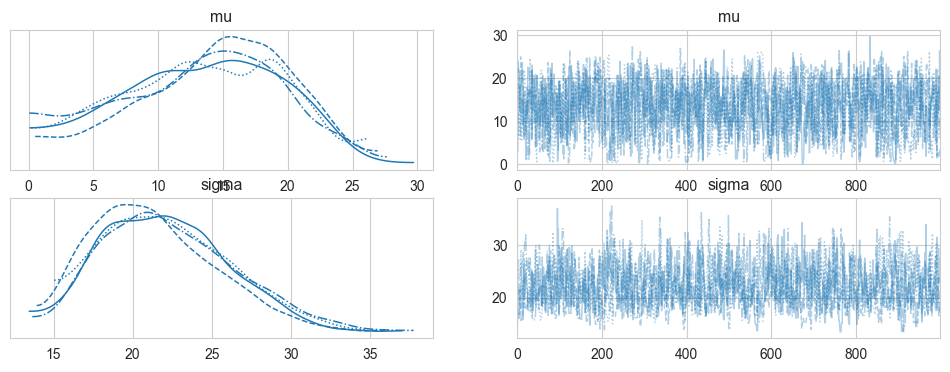

In [31]:
with pm.Model() as new_vehicle_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Uniform('mu', lower=0, upper=np.max(target_lsoa_data))  # Prior for the mean
    sigma = pm.Uniform('sigma', lower=0, upper=50)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    counts_observed = pm.TruncatedNormal('counts_observed', mu=mu, sigma=sigma, lower=0, observed=target_lsoa_data)

with new_vehicle_model:
    trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, progressbar=True)

az.plot_trace(trace)

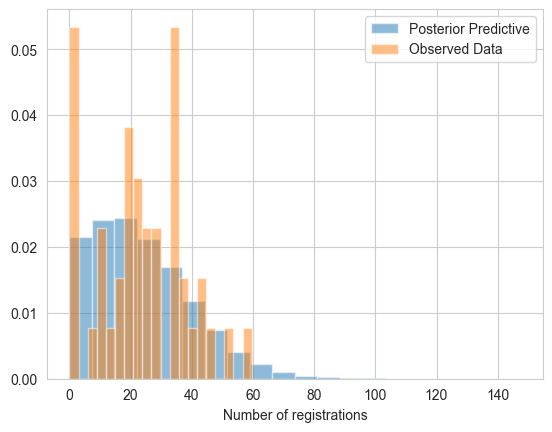

In [32]:
# Generate random samples from the posterior predictive distribution
with new_vehicle_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Plot the posterior predictive distribution
plt.hist(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), bins=20, density=True, alpha=0.5, label='Posterior Predictive')
plt.hist(target_lsoa_data, bins=20, density=True, alpha=0.5, label='Observed Data')
plt.xlabel('Number of registrations')
plt.legend()
plt.show()

1. The forecast_dates are generated using the `calculate_date_range` function, which creates a range of numeric dates between `t0` (the present date obtained from `calculate_t_present(bev_lsoa_i)`) and `t1` (the horizon date) at a given sample rate of 4. These dates represent the quarters over which the forecast will be made.

2. `n_sim` is set to 1000, indicating the number of simulated forecasting trajectories. Each trajectory represents a different possible scenario or simulation of new vehicle registrations.

3. The `new_vehicles_random` array is created by randomly sampling from the `posterior_predictive` distribution, which contains simulated values for the number of new vehicle registrations (for all vehicle types) based on the Bayesian model. Each row of `new_vehicles_random` represents the number of registrations for a specific quarter, and each column represents one simulation trajectory.

4. Four DataFrames (`new_ev_lsoa_forecast`, `new_ice_lsoa_forecast`, `new_bev_lsoa_forecast`, and `new_phev_lsoa_forecast`) are initialized to hold the forecasted number of registrations for Electric Vehicles (EV), ICE vehicles, BEV, and PHEV, respectively, for different simulation trajectories and quarters.

5. The code then enters a loop that iterates through each simulation trajectory (from 0 to n_sim). For each simulation, it calculates the forecasted number of registrations for EVs, ICE vehicles, BEVs, and PHEVs for each quarter using the sales shares of these vehicle types (`ev_sales_share_lsoa`, `ice_sales_share_lsoa`, `bev_sales_share_lsoa`, and `phev_sales_share_lsoa`) and the randomly generated `new_vehicles_random` values.

6. The resulting DataFrames (`new_ev_lsoa_forecast`, `new_ice_lsoa_forecast`, `new_bev_lsoa_forecast`, and `new_phev_lsoa_forecast`) store the forecasted number of new registrations for each vehicle type and simulation trajectory over the specified quarters.

In [33]:
# Creates a range of numeric dates between t0 and t1 at a given sample rate
forecast_dates = calculate_date_range(t0=calculate_t_present(bev_lsoa_i), t1=horizon, sample_rate=4)

n_sim = 1000 # Number of simulated forecasting trajectories
new_vehicles_random = np.random.choice(posterior_predictive.posterior_predictive.counts_observed.values.flatten(), size=(n_sim, len(forecast_dates)))

new_ev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_ice_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_bev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))
new_phev_lsoa_forecast = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1))

# Simulate new registrations
for i in range(0, n_sim):
    new_ev_lsoa_forecast[i+1] = ev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
    new_ice_lsoa_forecast[i+1] = ice_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_vehicles_random[i], axis='rows')
    new_bev_lsoa_forecast[i+1] = bev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')
    new_phev_lsoa_forecast[i+1] = phev_sales_share_lsoa.loc[forecast_dates, target_lsoa].multiply(new_ev_lsoa_forecast[i+1], axis='rows')

In [46]:
new_ev_lsoa_forecast

,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
2022.75,1.584178,1.509735,1.997393,1.020694,0.501978,1.956811,0.805539,3.778802,0.889188,1.622578,...,0.308395,1.365719,2.956934,0.036594,0.873366,1.995372,0.655898,0.635163,0.452404,0.787340
2023.00,2.973732,1.661648,0.858775,3.346826,1.723634,1.075240,4.516925,0.375435,0.410691,1.113475,...,1.155646,1.797357,2.973120,2.967247,3.144439,5.241904,2.085616,3.279256,3.049817,1.943500
2023.25,2.863490,2.470873,4.247670,0.241058,2.522266,1.243320,2.326094,3.340005,1.249244,0.767146,...,1.988871,1.236121,5.446677,1.574216,3.745259,3.330124,5.158884,1.309933,1.306843,0.074639
2023.50,5.542563,4.254751,6.433513,6.901096,7.281636,1.984233,2.419736,2.431676,5.827816,2.255432,...,3.669270,1.278103,0.818232,2.003866,3.307600,5.845253,7.178245,1.483582,0.196387,0.021116
2023.75,3.389158,2.454496,2.796710,4.154712,5.389875,5.397887,2.744888,4.696734,1.202020,2.477173,...,5.101361,7.552459,1.216935,2.973780,1.857840,5.053517,2.165054,2.585960,2.663837,3.934986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049.00,6.946533,31.138044,34.854902,2.865125,9.346244,57.187783,1.607563,30.632266,1.470185,17.121284,...,29.242251,40.289287,36.348701,30.364168,12.787599,21.286377,13.077487,7.973314,7.025653,23.670047
2049.25,40.204473,62.058854,25.444776,2.073089,16.053793,38.428885,23.113665,28.424912,13.047933,13.111811,...,29.303279,32.289771,24.073995,25.188169,15.880225,50.028948,31.729265,39.427454,43.616507,16.291637
2049.50,24.119320,25.656115,6.754487,40.550200,27.289318,15.311063,17.272724,1.829273,16.207595,15.288575,...,26.419251,35.486892,23.267150,19.718550,11.115730,10.168894,29.287254,43.043848,12.566418,31.321009
2049.75,4.887232,28.087506,17.733925,19.155453,15.681900,32.978577,6.913700,3.993171,18.303004,5.487125,...,27.855754,27.747476,13.096385,31.047974,1.601977,41.042378,39.929662,21.374674,64.711660,23.809387


### Plotting Percentile Ranges

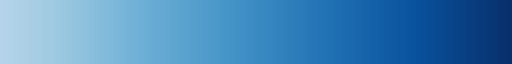

In [34]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.colormaps['Blues']
new_cmap = truncate_colormap(cmap, 0.3, 1)
new_cmap

In [35]:
NUM_COLORS = 20
cm = plt.get_cmap('Paired')
colors = [new_cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [36]:
def plot_probabilistic_vehicle_forecasts(df, historical_df, vehicle_type):
    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.01, axis=1).values, 
        y2=df.quantile(0.99, axis=1).values, 
        color=colors[19],
        alpha=0.1,
        label='1st to 99th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.05, axis=1).values, 
        y2=df.quantile(0.95, axis=1).values, 
        color=colors[19],
        alpha=0.2,
        label='5th to 95th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.1, axis=1).values, 
        y2=df.quantile(0.9, axis=1).values, 
        color=colors[19],
        alpha=0.4,
        label='10th to 90th Percentile'
    )

    ax.fill_between(
        x=df.index.values, 
        y1=df.quantile(0.25, axis=1).values, 
        y2=df.quantile(0.75, axis=1).values, 
        color=colors[19],
        alpha=0.6,
        label='Interquartile Range'
    )

    ax.plot(
        df.index.values, 
        df.quantile(0.5, axis=1).values, 
        linewidth=2, 
        c='black', 
        label='Median'
    )

    ax.plot(
        convert_dates_to_numeric(historical_df.dropna()),
        historical_df[target_lsoa].dropna().values,
        linewidth=2,
        c='green',
        label='Historical Data'
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, 
        labels, 
        # bbox_to_anchor=(1, 0.9), 
        title='Percentile', 
        title_fontsize=16, 
        fontsize=10
    )
    ax.set_title('Forecasted number of {}s for LSOA: {}'.format(vehicle_type, target_lsoa))
    ax.set_ylabel('Number of Registered Vehicles', fontsize=12)
    ax.set_xlabel('Time (Years)', fontsize=12)
    # ax.set_xlim(2022, horizon)
    plt.show()

### Account for uncertainty in vehicle retirement rate

#### *ICE*

In [37]:
# Calculate the difference between the (English) ICE stock in sequential quarters using .diff()
# Subtract this from the number of new ICE registrations in the region (England) to estimate the number of retired ICEs in England each quarter
# Divide this by the number of total number of ICEs registered in each quarter to estimate an ICE retirement rate for England
# Convert this to a numpy array using to_numpy()

ice_retirement_rates_np = (
    veh1153.loc[(veh1153['Geography'] == region) & (veh1153['Date Interval'] == 'Quarterly')].set_index('Date').loc[:, 'ICE'] - 
    veh1103.loc[(veh1103['Geography'] == region)].set_index('Date').loc[:, 'ICE'].diff()
).divide(veh1103.loc[(veh1103['Geography'] == region), ['Date', 'ICE']].set_index('Date')['ICE']).to_numpy()

# Replace any negative retirements rates with np.nan
ice_retirement_rates_np[ice_retirement_rates_np < 0] = np.nan

# Remove any np.nan values
ice_retirement_rates_np = ice_retirement_rates_np[~np.isnan(ice_retirement_rates_np)]
ice_retirement_rates_np

array([0.00583681, 0.01524846, 0.00431182, 0.007433  , 0.01570797,
       0.01675996, 0.01381743, 0.02064203, 0.01791176, 0.02146763,
       0.01143643, 0.01607625, 0.02079969, 0.01613976, 0.0134881 ,
       0.01848381, 0.01803162, 0.01687316, 0.01287251, 0.01510106,
       0.02007641, 0.01789411, 0.00921135, 0.01748127, 0.02019893,
       0.01585596, 0.00949129, 0.01557079, 0.02228001, 0.01834959,
       0.01220538, 0.01900227, 0.0195418 , 0.01495232, 0.01630631,
       0.02035339, 0.01704531, 0.02029675, 0.01396113, 0.01826822,
       0.02013184, 0.02017083, 0.0131868 , 0.01654303, 0.01768678,
       0.01756927, 0.01290866, 0.01534086, 0.01808429, 0.01260252,
       0.01851678, 0.00962102, 0.0163665 , 0.01604864, 0.00594068,
       0.01448902, 0.01383047, 0.01009146, 0.00819288, 0.01128529,
       0.01261462])

<Axes: >

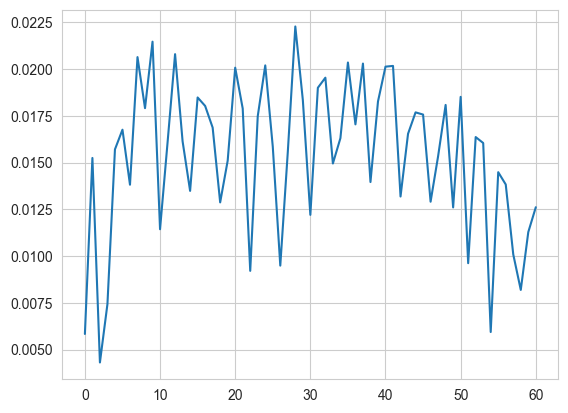

In [38]:
sns.lineplot(ice_retirement_rates_np)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

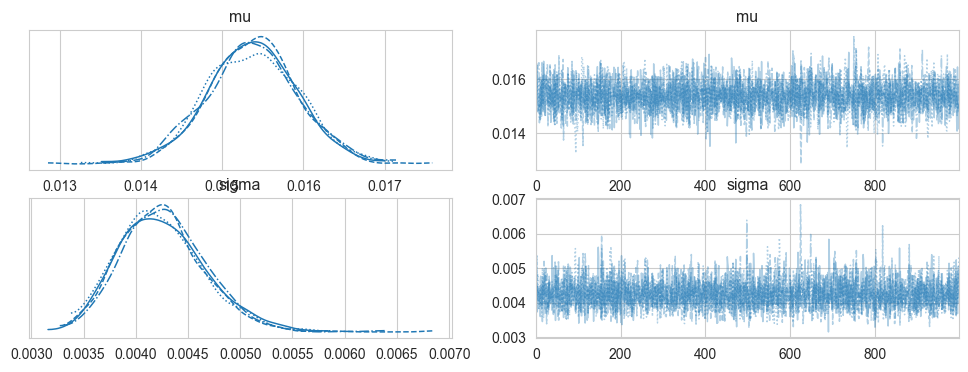

In [39]:
with pm.Model() as retired_ice_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Uniform('mu', lower=0, upper=0.5)  # Prior for the mean
    sigma = pm.Uniform('sigma', lower=0, upper=np.std(ice_retirement_rates_np) * 5)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    counts_observed = pm.TruncatedNormal('retirement_rates', mu=mu, sigma=sigma, lower=0, observed=ice_retirement_rates_np)

with retired_ice_model:
    retired_ice_trace = pm.sample(draws=1000, tune=2000, random_seed=RANDOM_SEED, progressbar=True)

az.plot_trace(retired_ice_trace)

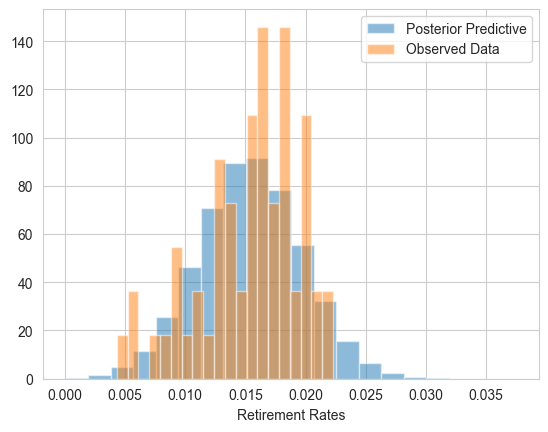

In [40]:
# Generate random samples from the posterior predictive distribution
with retired_ice_model:
    retired_ice_posterior_predictive = pm.sample_posterior_predictive(retired_ice_trace)

# Plot the posterior predictive distribution
plt.hist(retired_ice_posterior_predictive.posterior_predictive.retirement_rates.values.flatten(), bins=20, density=True, alpha=0.5, label='Posterior Predictive')
plt.hist(ice_retirement_rates_np, bins=20, density=True, alpha=0.5, label='Observed Data')
plt.xlabel('Retirement Rates')
plt.legend()
plt.show()

#### *BEV*

Due to the fact that BEVs and PHEVs are relatively new to the vehicle market, using historical data is not a reliable way of estimating their retirement rate.

Sampling: [mu, sigma, vehicle_lifetime]


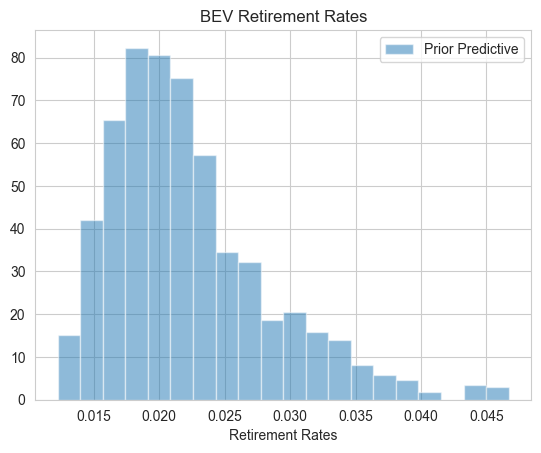

In [41]:
with pm.Model() as retired_bev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=12, sigma=3)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(4*vehicle_lifetime))

with retired_bev_model:
    retired_bev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution
plt.hist(
    retired_bev_prior_predictive.prior.retirement_rate.values.flatten()[retired_bev_prior_predictive.prior.retirement_rate.values.flatten()<0.05], 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend()
plt.title('BEV Retirement Rates')
plt.show()

#### *PHEV*

Sampling: [mu, sigma, vehicle_lifetime]


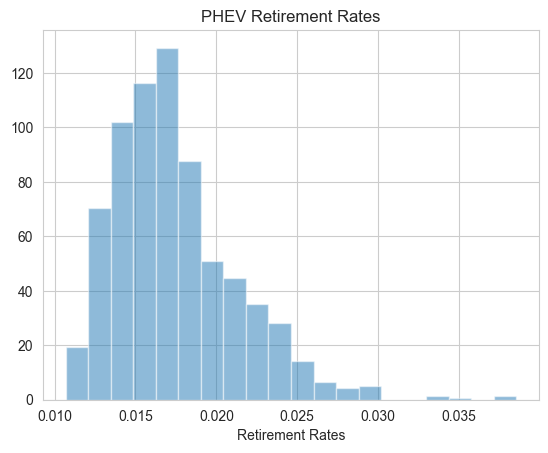

In [42]:
with pm.Model() as retired_phev_model:
    # Priors for the parameters (need to remove reference to target_lsoa_data)
    mu = pm.Normal('mu', mu=15, sigma=3)  # Prior for the mean
    sigma = pm.Exponential('sigma', lam=2)  # Prior for the standard deviation

    # Likelihood (sampling distribution) of the observed data
    vehicle_lifetime = pm.TruncatedNormal('vehicle_lifetime', mu=mu, sigma=sigma, lower=0)
    retirement_rate = pm.Deterministic('retirement_rate', 1/(4*vehicle_lifetime))

with retired_phev_model:
    retired_phev_prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

# Plot the prior predictive distribution
plt.hist(
    retired_phev_prior_predictive.prior.retirement_rate.values.flatten()[retired_phev_prior_predictive.prior.retirement_rate.values.flatten()<0.05], 
    bins=20, 
    density=True, 
    alpha=0.5, 
    label='Prior Predictive'
)
# plt.xlim(0, 0.5)
plt.xlabel('Retirement Rates')
plt.legend
plt.title('PHEV Retirement Rates')
plt.show()

1. Three DataFrames (`bev_forecast_lsoa`, `phev_forecast_lsoa`, and `ice_forecast_lsoa`) are created to hold the forecasted data for BEVs, PHEVs, and ICEs registrations in different LSOAs.

2. The most recent entries in the interpolated registration data for the three vehicle types (`bev_lsoa_i`, `phev_lsoa_i`, and `ice_lsoa_i`) are used to populate the first row of the forecast DataFrames. This data represents the starting registrations for the forecast period.

3. Random retirement rates are sampled from posterior/prior predictive distributions for ICEs, BEVs and PHEVs. These rates are then used to simulate the retirement of vehicles from the existing registered fleet during the forecast period. The sampled rates represent the probability of vehicles being retired each quarter.

4. The forecasting process iterates over each forecasted date (quarter). For each date, the forecasted number of new registrations for BEV, PHEV, and ICE (`new_bev_lsoa_forecast`, `new_phev_lsoa_forecast`, and `new_ice_lsoa_forecast`) is added to the previous quarter's forecasted registrations, and the number of retired vehicles is subtracted based on the sampled retirement rates. This results in new forecasted registrations for each vehicle type for the given LSOA and quarter.

5. The resulting forecast DataFrames (`bev_forecast_lsoa`, `phev_forecast_lsoa`, and `ice_forecast_lsoa`) are then rounded to whole numbers, as vehicle registrations are typically whole numbers.

6. Finally, the forecasted registration data for each vehicle type and LSOA are plotted separately to visualize the simulation-based forecasts over time.

<Axes: >

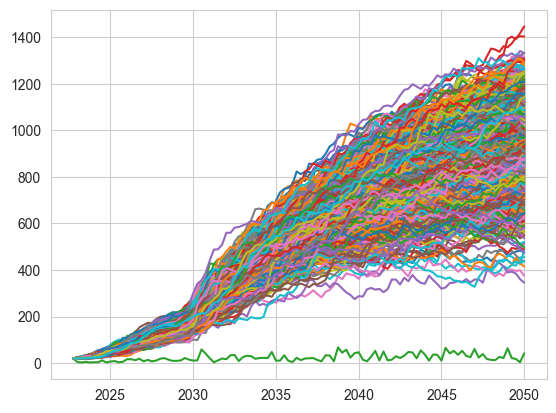

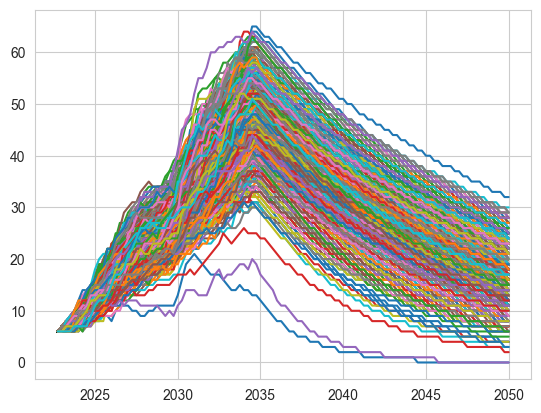

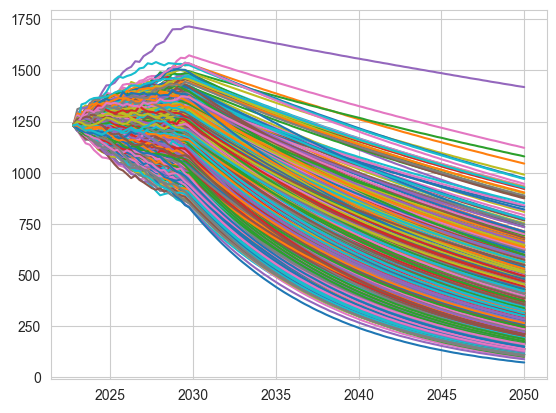

In [43]:
# Create dataframes that contain a column for each simulation and a row for each forecasted date
bev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
phev_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)
ice_forecast_lsoa = pd.DataFrame(index=forecast_dates, columns=range(1, n_sim+1), dtype=float)

# Populate forecast with inital starting registrations
bev_forecast_lsoa.iloc[0] = bev_lsoa_i[target_lsoa].iloc[-1]
phev_forecast_lsoa.iloc[0] = phev_lsoa_i[target_lsoa].iloc[-1]
ice_forecast_lsoa.iloc[0] = ice_lsoa_i[target_lsoa].iloc[-1]

# Randomly sample retirement rates from posterior/prior predictive distributions
ice_retirement_rates_random = np.random.choice(retired_ice_posterior_predictive.posterior_predictive.retirement_rates.values.flatten(), size=(n_sim))
bev_retirement_rates_random = np.random.choice(retired_bev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))
phev_retirement_rates_random = np.random.choice(retired_phev_prior_predictive.prior.retirement_rate.values.flatten(), size=(n_sim))

# Making the forecasts by adding new registrations and removing retired vehicles
for i in range(1, len(forecast_dates)):
    bev_forecast_lsoa.loc[forecast_dates[i]] = bev_forecast_lsoa.loc[forecast_dates[i-1]] + new_bev_lsoa_forecast.loc[forecast_dates[i]] - (bev_retirement_rates_random * bev_forecast_lsoa.loc[forecast_dates[i-1]])
    phev_forecast_lsoa.loc[forecast_dates[i]] = phev_forecast_lsoa.loc[forecast_dates[i-1]] + new_phev_lsoa_forecast.loc[forecast_dates[i]] - (phev_retirement_rates_random * phev_forecast_lsoa.loc[forecast_dates[i-1]])
    ice_forecast_lsoa.loc[forecast_dates[i]] = ice_forecast_lsoa.loc[forecast_dates[i-1]] + new_ice_lsoa_forecast.loc[forecast_dates[i]] - (ice_retirement_rates_random * ice_forecast_lsoa.loc[forecast_dates[i-1]])

bev_forecast_lsoa = round(bev_forecast_lsoa)
phev_forecast_lsoa = round(phev_forecast_lsoa)
ice_forecast_lsoa = round(ice_forecast_lsoa)

bev_forecast_lsoa.plot(legend=False)
phev_forecast_lsoa.plot(legend=False)
ice_forecast_lsoa.plot(legend=False)

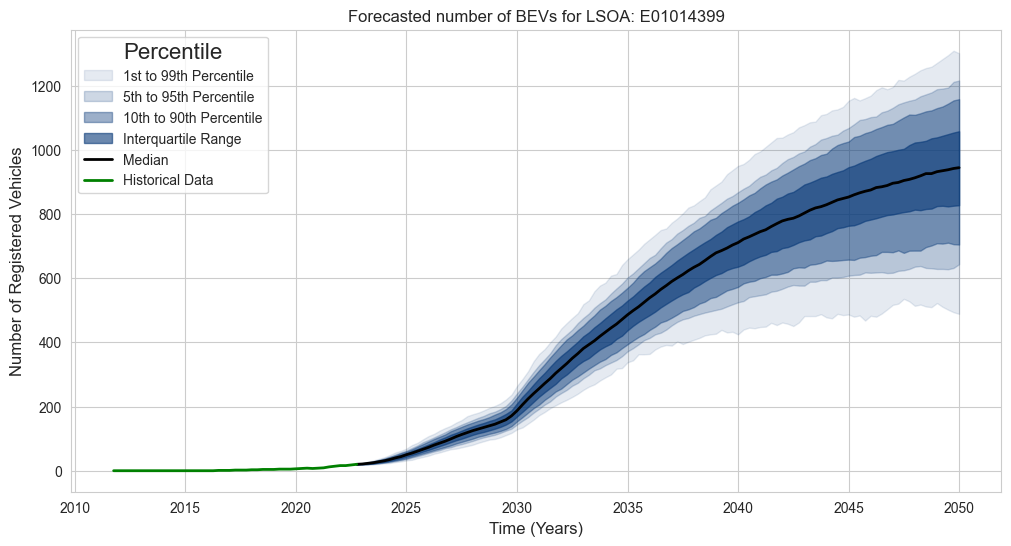

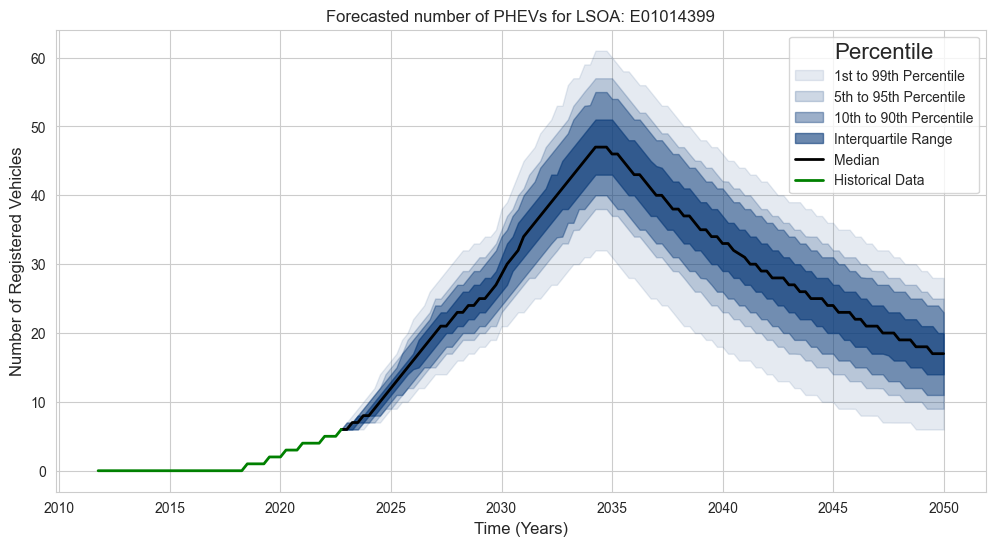

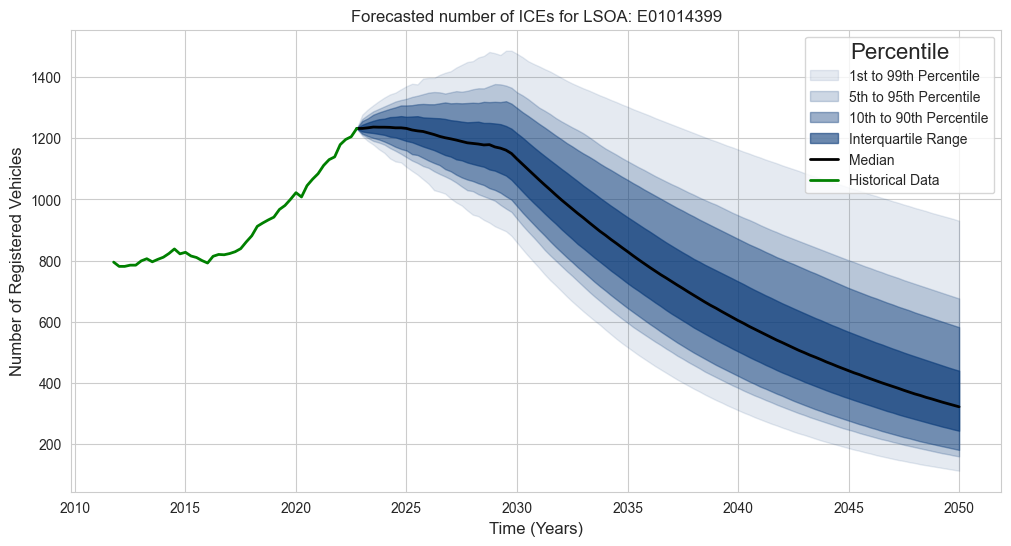

In [44]:
plot_probabilistic_vehicle_forecasts(bev_forecast_lsoa, bev_lsoa_i, 'BEV')
plot_probabilistic_vehicle_forecasts(phev_forecast_lsoa, phev_lsoa_i, 'PHEV')
plot_probabilistic_vehicle_forecasts(ice_forecast_lsoa, ice_lsoa_i, 'ICE')